In [1]:
import numpy as np

import os
home = os.path.expanduser("~")
import glob
import scipy
import scipy.integrate

import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt 
import ipywidgets as widgets#  HBox, VBox, IntSlider, Play, jslink, Layout, Label
from IPython.display import display, HTML
import pickle
import gzip

snscolors = sns.color_palette()
import importlib


### Misc functions

In [2]:
edge_to_bin = lambda x:  (x[1:]+x[:-1])/2

In [3]:
def getquantiles(x,y,qvalues=[0.5]):
    dx = x[1]-x[0]
    # make sure y is normalized
    y = y.copy()/np.sum(y)/dx
    f = scipy.interpolate.interp1d(x, np.cumsum(y)*(dx))
    quantiles = np.reshape(np.array( [ scipy.optimize.brentq(lambda d: f(d)-q,x[0],x[-1]) for q in qvalues]),-1)
    return quantiles

def getmean(x,y):  # gets the mean of a probability distribution defined by x and y
    return np.sum(x*y)/np.sum(y)
def getstd(x,y):
    mn = getmean(x,y)
    return np.sqrt(np.sum((x-mn)**2*y)/np.sum(y))

In [4]:
def plotalphaline(x,y,c,alphavals,ax='',zorder=-1,linewidth=1,dxfrac=1,skip=1):
    if ax=='':
        f,ax = plt.subplots(1,1)
    for k in range(0,len(x)-skip,skip):
        dx = x[k+skip]-x[k]
        dy = y[k+skip]-y[k]
        ax.plot([x[k],x[k]+dxfrac*dx],[y[k],y[k]+dxfrac*dy],c=c,alpha=np.mean(alphavals[k:k+1+skip]),zorder=zorder,linewidth=linewidth,rasterized=True)
        
def plotalphafill(x,y1,y2,c,alphavals,ax='',zorder=-1,dxfrac=1,skip=1):
    if ax=='':
        f,ax = plt.subplots(1,1)
    for k in range(0,len(x)-skip,skip):
        dx = x[k+skip]-x[k]
        dy1 = y1[k+skip]-y1[k]
        dy2 = y2[k+skip]-y2[k]
        ax.fill_between([x[k],x[k]+dxfrac*dx],[y1[k],y1[k]+dxfrac*dy1],[y2[k],y2[k]+dxfrac*dy2],color=c,alpha=np.mean(alphavals[k:k+1+skip]),zorder=zorder,linewidth=0,rasterized=True)     

# (1) Import data and define model functions

In [5]:
[degreebins,distbins,d1D,exampledata] = pickle.load(open(resultsdir+'distributions+exampledata.pkl','rb'))
[distributions1D,distributions1D_problow,distributions1D_probhigh,distributions1D_blind] = d1D
degreevalues = edge_to_bin(degreebins)
allnumfish=[10,30,70,151]

In [101]:
qvalues = np.linspace(0,1,9)[1:-1]
# qvalues = [0.5]
print('quantile values:', qvalues)
dataq = [getquantiles(degreevalues,d,qvalues) for d in distributions1D]
dataq_problow = [getquantiles(degreevalues,d,qvalues) for d in distributions1D_problow]
dataq_probhigh = [getquantiles(degreevalues,d,qvalues) for d in distributions1D_probhigh]
dataq_blind = [getquantiles(degreevalues,d,qvalues) for d in distributions1D_blind]

datamean_problow = [getmean(degreevalues,d) for d in distributions1D_problow]
datamean_probhigh = [getmean(degreevalues,d) for d in distributions1D_probhigh]
datastd_probhigh = [getstd(degreevalues,d) for d in distributions1D_probhigh]
datamean_blind = [getmean(degreevalues,d) for d in distributions1D_blind]

quantile values: [0.125 0.25  0.375 0.5   0.625 0.75  0.875]


### Model function definitions

In [109]:
def get_modeldist1d(lambdaval,sigma, numxvalues = 200, numalphavalues = 25, numdegreebins=50):
    xvalues = np.linspace(0,1,numxvalues)
    x_shellarea = np.pi * (xvalues[1:]**2 - xvalues[:-1]**2)
    if sigma==0:
        alphavalues=np.array([1])
        alphaprobs=np.array([1])
    else:
        alphavalues = np.linspace(0,3,numalphavalues)
        alphaprobs = np.exp(-(alphavalues-1)**2/(2*sigma**2))
    
    detection_x = np.zeros((len(alphavalues),len(xvalues)))
    for dnum in range(len(alphavalues)):
        for xnum in range(len(xvalues)):
            x = xvalues[xnum]
            dist = lambda th: x*np.cos(th)+np.sqrt(1-(x*np.sin(th))**2)
            detectionprob = lambda th: np.exp(-lambdaval*dist(th)*alphavalues[dnum])
            detection_x[dnum,xnum] = scipy.integrate.quad(detectionprob, -np.pi,np.pi)[0] / (2*np.pi)    
            
    alldetect = np.reshape(edge_to_bin(detection_x.T).T,-1)
    allcounts = np.reshape(alphaprobs[:,np.newaxis]*x_shellarea[np.newaxis,:],-1)
    statistic, bin_edges, _ = scipy.stats.binned_statistic(alldetect,allcounts, statistic='sum',bins=np.linspace(0,1,numdegreebins))
    statistic = statistic / (np.sum(statistic)*(bin_edges[1]-bin_edges[0]))  # normalize
    return edge_to_bin(bin_edges), statistic

def get_modeldist1d_group(lambdaval,sigma, numxvalues = 200, numalphavalues = 25, numdegreebins=50):
    xvalues = np.linspace(0,1,numxvalues)
    x_shellarea = np.pi * (xvalues[1:]**2 - xvalues[:-1]**2)
    if sigma==0:
        alphavalues=np.array([1])
        alphaprobs=np.array([1])
    else:
        alphavalues = np.linspace(0,3,numalphavalues)
        alphaprobs = np.exp(-(alphavalues-1)**2/(2*sigma**2))
    
    detection_x = np.zeros((len(alphavalues),len(xvalues)))
    for dnum in range(len(alphavalues)):
        for xnum in range(len(xvalues)):
            x = xvalues[xnum]
            dist = lambda th: x*np.cos(th)+np.sqrt(1-(x*np.sin(th))**2)
            detectionprob = lambda th: np.exp(-lambdaval*dist(th)*alphavalues[dnum])
            detection_x[dnum,xnum] = scipy.integrate.quad(detectionprob, -np.pi,np.pi)[0] / (2*np.pi)    
            
    detect_per_alpha = np.sum(edge_to_bin(detection_x.T).T * x_shellarea[np.newaxis,:],axis=-1) / np.sum(x_shellarea)
    groupdetect, bin_edges = np.histogram(detect_per_alpha,weights=alphaprobs/np.sum(alphaprobs),density=True,bins=np.linspace(0,1,numdegreebins))
    
    return edge_to_bin(bin_edges), groupdetect

def getbothdists(lambdaval,sigma, numxvalues = 200, numalphavalues = 25, numdegreebins=50):
    ######  BETWEEEN THESE, SAME AS ABOVE FUNCTIONS (yes, should change to clean up, but this easier)
    xvalues = np.linspace(0,1,numxvalues)
    x_shellarea = np.pi * (xvalues[1:]**2 - xvalues[:-1]**2)
    if sigma==0:
        alphavalues=np.array([1])
        alphaprobs=np.array([1])
    else:
        alphavalues = np.linspace(0,3,numalphavalues)
        alphaprobs = np.exp(-(alphavalues-1)**2/(2*sigma**2))
    
    detection_x = np.zeros((len(alphavalues),len(xvalues)))
    for dnum in range(len(alphavalues)):
        for xnum in range(len(xvalues)):
            x = xvalues[xnum]
            dist = lambda th: x*np.cos(th)+np.sqrt(1-(x*np.sin(th))**2)
            detectionprob = lambda th: np.exp(-lambdaval*dist(th)*alphavalues[dnum])
            detection_x[dnum,xnum] = scipy.integrate.quad(detectionprob, -np.pi,np.pi)[0] / (2*np.pi)   
    ######
                   
    detect_per_alpha = np.sum(edge_to_bin(detection_x.T).T * x_shellarea[np.newaxis,:],axis=-1) / np.sum(x_shellarea)
    groupdetect, group_bin_edges = np.histogram(detect_per_alpha,weights=alphaprobs/np.sum(alphaprobs),density=True,bins=np.linspace(0,1,numdegreebins))            
    
    alldetect = np.reshape(edge_to_bin(detection_x.T).T,-1)
    allcounts = np.reshape(alphaprobs[:,np.newaxis]*x_shellarea[np.newaxis,:],-1)
    statistic, bin_edges, _ = scipy.stats.binned_statistic(alldetect,allcounts, statistic='sum',bins=np.linspace(0,1,numdegreebins))
    statistic = statistic / (np.sum(statistic)*(bin_edges[1]-bin_edges[0]))  # normalize
    
    return edge_to_bin(bin_edges), statistic, edge_to_bin(bin_edges), groupdetect

[0.4895327871505522, array([0.47208936])]


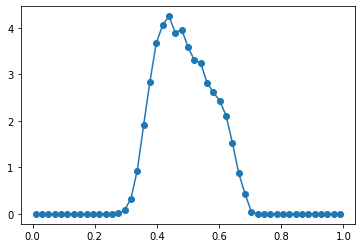

In [8]:
# calculate distribution for single lambdavalue
lambdaval = 1
sigmaval = 0.1
xtp, ytp = get_modeldist1d(lambdaval,sigmaval,numxvalues=100,numalphavalues=50)
plt.plot(xtp,ytp,'-o')
modelmean = np.sum(xtp*ytp)/np.sum(ytp)
modelmedian = getquantiles(xtp,ytp,[0.5])
print([modelmean,modelmedian])

# (2) Fit $\lambda_0$, $q$, and $\sigma$ to data, as calculated from incomplete (probabilistic) blocking

In [142]:
# def modelquantiles_multiple(lambda_scaling,scalingexp,qvalues=[0.5]):
#     lambdavals = lambda_scaling * (np.array(allnumfish)**scalingexp)
#     return [getquantiles(*get_modeldist1d(l,sigmaval,numxvalues=100,numalphavalues=25),qvalues) for l in lambdavals]

# def costfn_median(params,data):
#     modelq = modelquantiles_multiple(*params)
#     return np.sum((np.array(data) - np.array(modelq))**2)

def modelmean_multiple(lambda_scaling,scalingexp):
    lambdavals = lambda_scaling * (np.array(allnumfish)**scalingexp)
    return [getmean(*get_modeldist1d(l,0,numxvalues=50,numalphavalues=25)) for l in lambdavals]

def costfn_mean(params,data):
    modelmean = modelmean_multiple(*params)
    return np.sum((np.array(data) - np.array(modelmean))**2)

def costfn_mean_singleparam(lambda_scaling,scalingexp,data):
    modelmean = modelmean_multiple(lambda_scaling,scalingexp)
    return np.sum((np.array(data) - np.array(modelmean))**2)

def modelgroupstd_multiple(sigma,lambda_scaling,scalingexp):
    lambdavals = lambda_scaling * (np.array(allnumfish)**scalingexp)
    return np.array([getstd(*get_modeldist1d_group(l,sigma,numxvalues=50,numalphavalues=25)) for l in lambdavals])*np.array(allnumfish)

def costfn_std(sigma,lambda_scaling,scalingexp,data):
    modelstd = modelgroupstd_multiple(sigma,lambda_scaling,scalingexp)
    return np.sum((np.array(data) - np.array(modelstd))**2)

In [143]:
datadist = distributions1D_probhigh
# use this to fit median instead of mean
# data_to_fit = dataq_probhigh
# fn = lambda x: costfn_median(x,data_to_fit)
data_to_fit = datamean_probhigh
fn = lambda x: costfn_mean(x,data_to_fit)
fit = scipy.optimize.minimize(fn,[0.09,0.65],method='Nelder-Mead')

print(fit)
lambda_opt,scalingexp = fit.x

 final_simplex: (array([[0.12911366, 0.57959358],
       [0.12913986, 0.57951889],
       [0.12909832, 0.57961601]]), array([0.00078135, 0.00078135, 0.00078135]))
           fun: 0.0007813542177951657
       message: 'Optimization terminated successfully.'
          nfev: 68
           nit: 31
        status: 0
       success: True
             x: array([0.12911366, 0.57959358])


In [144]:
# Fit sigma to the group mean values
[indiv_mean,indiv_std,group_mean,group_std] = pickle.load(open('savedresults/ind-groupmeans.pkl','rb'))

fn = lambda x: costfn_std(x,lambda_opt,scalingexp,group_std)
fit = scipy.optimize.minimize(fn,0.25,method='Nelder-Mead')
print(fit)
sigmaval = fit.x

 final_simplex: (array([[0.26347656],
       [0.26337891]]), array([2.95391774, 2.95395549]))
           fun: 2.953917738735794
       message: 'Optimization terminated successfully.'
          nfev: 16
           nit: 8
        status: 0
       success: True
             x: array([0.26347656])


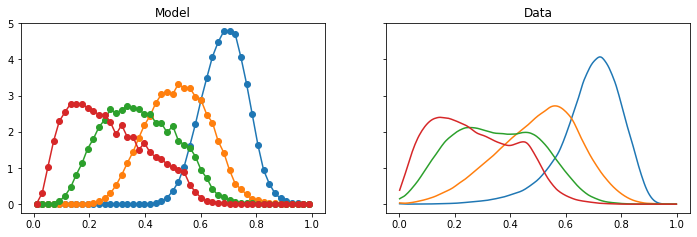

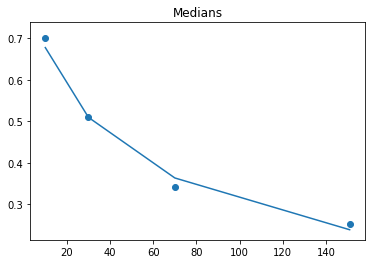

In [145]:
f,ax = plt.subplots(1,2,sharex=True,sharey=True)
f.set_size_inches(12,3.5)

# calculate distribution for single lambdavalue
modelmed = np.zeros(4)

for i in range(4):
    N = allnumfish[i]
    xtp, ytp = get_modeldist1d(lambda_opt*(N**scalingexp),sigmaval,numxvalues=100,numalphavalues=50)
    modelmed[i] = getquantiles(xtp,ytp,[0.5])
    ax[0].plot(xtp,ytp,'-o')
ax[0].set_title('Model')

datamed = np.zeros(4)
for i in range(4):
    xtp, ytp = degreevalues,datadist[i]
    ax[1].plot(xtp,ytp)
    datamed[i] = getquantiles(xtp, ytp, [0.5])

ax[1].set_title('Data')
plt.show()

plt.scatter(allnumfish,datamed)
plt.plot(allnumfish,modelmed)
plt.title('Medians')
plt.show()

# Plots to output

## Area distributions used in the model

In [169]:
savefigures = True
if savefigures:
    import matplotlib.backends.backend_pdf
    pdf = matplotlib.backends.backend_pdf.PdfPages('../image-output/modelfigures.pdf')

In [170]:
# These are from the data - use individual area scaling, because its the most representative
data_mean_area = np.array([359.95158732875495, 1626.0351685450346, 3018.1988591849804, 5562.254727960624])
data_indiv_mean_area = np.array([53.35393148612645, 48.945101248358306, 39.32674543782334, 33.109866598076025])

/home/jacob/anaconda3/envs/bees/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys


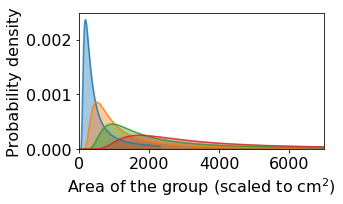

In [171]:
f,ax = plt.subplots(1,1)
f.set_size_inches(4.4,2.5)

numalphavalues = 500
alphavalues = np.linspace(0.1,3,numalphavalues)
Areavalues = np.linspace(0,4*np.pi**2,numalphavalues)
Areaprobs = np.exp(-(np.sqrt(np.pi/Areavalues)-1)**2/(2*sigmaval**2))

x,y = Areavalues,Areaprobs
ynorm = y/(np.sum(y)*(x[1]-x[0]))
model_mean_area = np.sum(ynorm*x)/ np.sum(ynorm)

for case in range(4):
    areascaling = data_indiv_mean_area[case]*allnumfish[case]/model_mean_area
    x,y = areascaling *Areavalues,Areaprobs
    ynorm = y/(np.sum(y)*(x[1]-x[0]))
    ax.plot(x,ynorm,alpha=0.8,color=snscolors[case])
    ax.fill_between(x,ynorm,alpha=0.4,color=snscolors[case])
plt.xlim([0,7000])
# ax.legend(fontsize=16,bbox_to_anchor=(1,1))
ax.tick_params(labelsize=16)
ax.set_ylabel('Probability density',fontsize=16)
ax.set_xlabel('Area of the group (scaled to cm$^2$)',fontsize=16)
ax.set_ylim(bottom=0)
pdf.savefig(f) if savefigures else None 
plt.show()

0
1
2
3


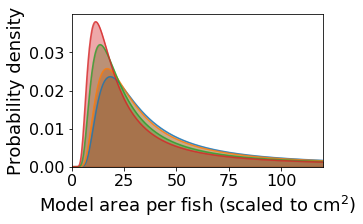

In [172]:
f,ax = plt.subplots(1,1)
f.set_size_inches(4.5,2.8)

numalphavalues = 500
alphavalues = np.linspace(0.1,3,numalphavalues)
Areavalues = np.linspace(0.01,4*np.pi**2,numalphavalues)
Areaprobs = np.exp(-(np.sqrt(np.pi/Areavalues)-1)**2/(2*sigmaval**2))

x,y = Areavalues,Areaprobs
ynorm = y/(np.sum(y)*(x[1]-x[0]))
model_mean_area = np.sum(ynorm*x)/ np.sum(ynorm)

for case in range(4):
    print(case)
    areascaling = data_indiv_mean_area[case]/model_mean_area
    x,y = areascaling *Areavalues,Areaprobs
    ynorm = y/(np.sum(y)*(x[1]-x[0]))
    ax.plot(x,ynorm,alpha=0.8,color=snscolors[case])
    ax.fill_between(x,ynorm,alpha=0.4,color=snscolors[case])
plt.xlim([0,120])
# ax.legend(fontsize=16,bbox_to_anchor=(1,1))
ax.tick_params(labelsize=16)
ax.set_ylabel('Probability density',fontsize=18)
ax.set_xlabel('Model area per fish (scaled to cm$^2$)',fontsize=18)
ax.set_ylim(bottom=0)
pdf.savefig(f) if savefigures else None 
plt.show()

## Vary parameters in the model to show it affects trends

In [173]:
lambda0_bestfit = lambda_opt
q_bestfit = scalingexp


lambda0_toplots = np.array([0.5,1,2])*lambda0_bestfit
q_toplots = [0.35,q_bestfit,0.95]
q_toplots = np.array([0.5,1,2])*q_bestfit
allNvalues = np.array([10,30,60,100,150])
allNvalues = np.arange(0,152,2)
# allNvalues = np.arange(0,1000,10)
allmean = np.zeros((len(lambda0_toplots),len(q_toplots),len(allNvalues)) )
allmean_withsigma = np.zeros((len(lambda0_toplots),len(q_toplots),len(allNvalues)) )
for i,lambda0_toplot in enumerate(lambda0_toplots):
    for j,q_toplot in enumerate(q_toplots):
        for k,N in enumerate(allNvalues):
            lambdaval = lambda0_toplot * N**q_toplot
            xtp, ytp = get_modeldist1d(lambdaval,0,numxvalues=25,numalphavalues=25)
            allmean[i,j,k] = np.sum(xtp*ytp)/np.sum(ytp)
#             xtp, ytp = get_modeldist1d(lambdaval,0.25,numxvalues=25,numalphavalues=25)
#             allmean_withsigma[i,j,k] = np.sum(xtp*ytp)/np.sum(ytp)
#             allmedian[i,j,k] = getquantiles(xtp,ytp,[0.5])


In [174]:
def getmodelapprox(x,coeffs):
    return np.exp(-x)*np.sum([c*x**i for i,c in enumerate(coeffs)],axis=0)

# Expansion coefficents obtained in Mathematica
coeffs1 = [1]
coeffs2 = [1, 1/8, 1/8]
coeffs4 = [1, 9/64, 9/64, 1/96, 1/192]
coeffs6 = [1, 149/1024, 149/1024, 5/384, 19/3072, 1/3072, 1/9216]
coeffs8 = [1, 2419/16384, 2419/16384, 347/24576, 323/49152, 53/122880, 49/368640, 1/184320, 1/737280]
coeffs10 = [1, 19499/131072, 19499/131072, 361/24576, 887/131072, 949/1966080, 283/1966080, 11/1474560, 1/589824, 1/17694720, 1/88473600]
coeffs12 = [1, 156685/1048576, 156685/1048576, 23629/1572864, 7215/1048576, 671/1310720, 59/393216, 47/5505024, 41/22020096, 79/990904320, 71/4954521600, 1/2477260800, 1/14863564800]
model_approx = lambda x: getmodelapprox(x,coeffs6)

In [175]:
print(coeffs6)
np.array(coeffs6)

[1, 0.1455078125, 0.1455078125, 0.013020833333333334, 0.006184895833333333, 0.0003255208333333333, 0.00010850694444444444]


array([1.00000000e+00, 1.45507812e-01, 1.45507812e-01, 1.30208333e-02,
       6.18489583e-03, 3.25520833e-04, 1.08506944e-04])

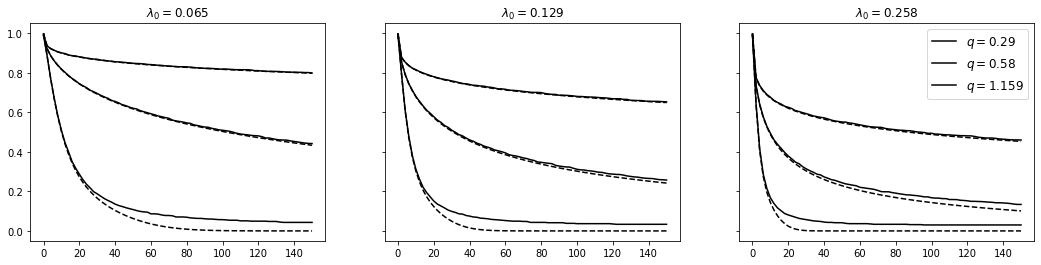

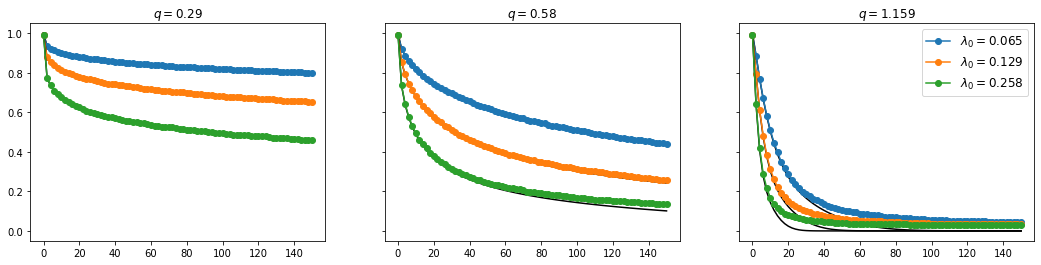

In [176]:
f,ax = plt.subplots(1,len(lambda0_toplots),sharex=True,sharey=True)
f.set_size_inches(6*len(ax),4)
for i,lambda0_toplot in enumerate(lambda0_toplots):
    for j,q_toplot in enumerate(q_toplots):
        lambdavals = lambda0_toplot * allNvalues**q_toplot
        ax[i].plot(allNvalues,model_approx(lambdavals),c='k',linestyle='--')        
        ax[i].plot(allNvalues,allmean[i,j],'-',label='$q='+str(np.round(q_toplot,3))+'$',c='k')
#         ax[i].plot(allNvalues,allmean_withsigma[i,j],'--o',c=snscolors[j])
        ax[i].set_title('$\lambda_0='+str(np.round(lambda0_toplot,3))+'$')
ax[-1].legend(fontsize=12,bbox_to_anchor=(1,1))
plt.show()

f,ax = plt.subplots(1,len(q_toplots),sharex=True,sharey=True)
f.set_size_inches(6*len(ax),4)
for i,lambda0_toplot in enumerate(lambda0_toplots):
    for j,q_toplot in enumerate(q_toplots):
        lambdavals = lambda0_toplot * allNvalues**q_toplot
        ax[j].plot(allNvalues,model_approx(lambdavals),c='k')
        ax[j].plot(allNvalues,allmean[i,j],'-o',label='$\lambda_0='+str(np.round(lambda0_toplot,3))+'$')
        ax[j].set_title('$q='+str(np.round(q_toplot,3))+'$')
ax[-1].legend(fontsize=12,bbox_to_anchor=(1,1))
plt.show()

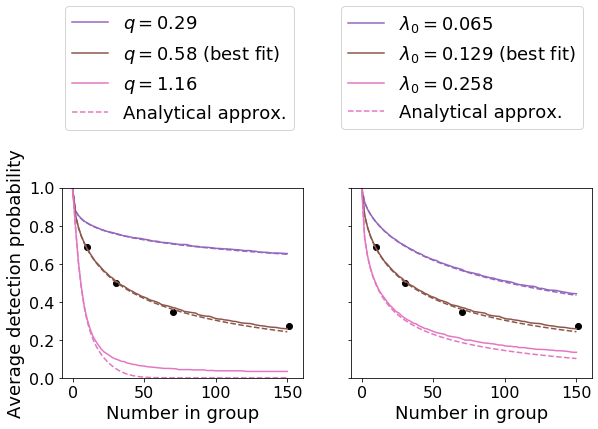

In [177]:
f,ax = plt.subplots(1,2,sharex=True,sharey=True)
f.set_size_inches(9.5,3.5)

# vary q
a=ax[0]
i=1
lambda0_toplot = lambda0_toplots[i]
for j,q_toplot in enumerate(q_toplots):
    lambdavals = lambda0_toplot * allNvalues**q_toplot        
    a.plot(allNvalues,allmean[i,j],'-',label='$q='+str(np.round(q_toplot,2))+'$'+(' (best fit)' if j==1 else ''),c=snscolors[j+4])
    a.plot(allNvalues,model_approx(lambdavals),c=snscolors[j+4],linestyle='--',label=('Analytical approx.' if j==2 else None))

# vary lambda0
a=ax[1]
j=1
q_toplot = q_toplots[j]
for i,lambda0_toplot in enumerate(lambda0_toplots):
    lambdavals = lambda0_toplot * allNvalues**q_toplot        
    a.plot(allNvalues,allmean[i,j],'-',label='$\lambda_0='+str(np.round(lambda0_toplot,3))+'$'+(' (best fit)' if i==1 else ''),c=snscolors[i+4])
    a.plot(allNvalues,model_approx(lambdavals),c=snscolors[i+4],linestyle='--',label=('Analytical approx.' if i==2 else None))
# Common and formatting
for a in ax:
    a.scatter(allnumfish,datamean_probhigh,c='k')
    a.legend(fontsize=18,bbox_to_anchor=(1,2))
    a.set_ylim([0,1])
    a.tick_params(labelsize=16)
    a.set_xlabel('Number in group',fontsize=18)
ax[0].set_ylabel('Average detection probability',fontsize=18)

pdf.savefig(f) if savefigures else None 
plt.savefig('../image-output/temp.pdf')
plt.show()

##  Detection Coverage

In [178]:
# Calculate for distributions
    
numxvalues = 400
numalphavalues = 100

alltp = []
for case in range(4):
    print(case)
    N = allnumfish[case]
    xtp, ytp = get_modeldist1d(lambda_opt*(N**scalingexp),sigmaval,numxvalues=numxvalues,numalphavalues=numalphavalues,numdegreebins=100)
    alltp.append([xtp,ytp])

0
1
2
3


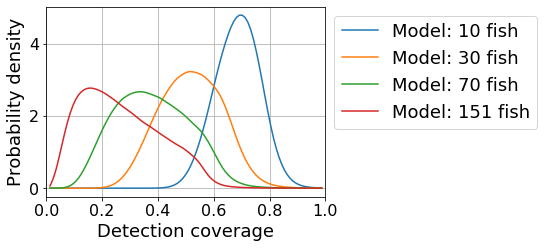

In [179]:
# Plot, using smoothing instead of making the number of points super huge
smoothfn = lambda x: scipy.ndimage.gaussian_filter1d(x,sigma=1.5)

f,ax=plt.subplots(1,1)
f.set_size_inches(5,3.5)
for case in range(4):
    xtp,ytp = alltp[case]
    plt.plot(smoothfn(xtp),smoothfn(ytp),c=snscolors[case],linestyle='-',label='Model: '+str(allnumfish[case])+' fish')
#     plt.plot(xtp,ytp,c=snscolors[case],linestyle='--',label='Model: '+str(allnumfish[case])+' fish')

# ax[1] formatting
ax.set_xlabel('Detection coverage',fontsize=18)
ax.set_ylabel('Probability density',fontsize=18)
ax.set_xlim([0,1])

# common formatting
ax.tick_params(labelsize=16)
ax.legend(fontsize=18,bbox_to_anchor=(1,1))
ax.grid(True)
#     a.minorticks_on()
#     a.grid(True,which='minor',c='grey',alpha=0.15)
# plt.savefig('../image-output/fig2b-probdists.pdf')
pdf.savefig(f) if savefigures else None 
# plt.savefig()
plt.show()

## Model-data comparison

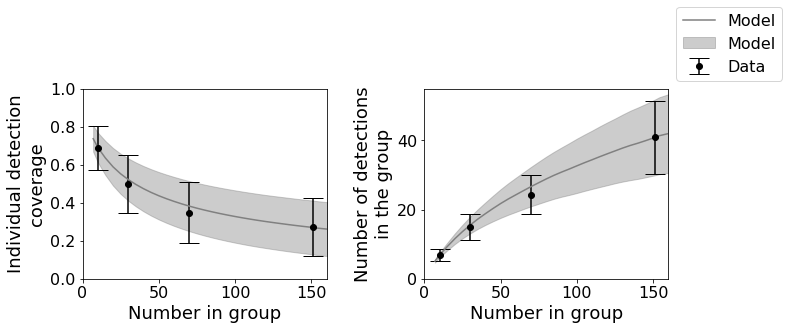

In [186]:
# Calculate
Nvalues = np.arange(5,175,5)
meantp_group, stdtp_group, meantp_indiv, stdtp_indiv = np.tile(0.0,(4,len(Nvalues)))
for i,N in enumerate(Nvalues):
    x_indiv, y_indiv, x_group, y_group = getbothdists(lambda_opt*(N**scalingexp),sigmaval,numxvalues=50,numalphavalues=50)
    meantp_indiv[i] = getmean(x_indiv,y_indiv)
    stdtp_indiv[i] = getstd(x_indiv,y_indiv)
    meantp_group[i], stdtp_group[i] = getmean(x_group,y_group)*N, getstd(x_group,y_group)*N  # model scaling by N here is correct
    
# Plot, using smoothing instead of making the number of points super huge
smoothfn = lambda x: scipy.ndimage.gaussian_filter1d(x,sigma=1)
f,ax = plt.subplots(1,2,sharex=True)
f.set_size_inches(10.5,3.5)

a=ax[0]
a.errorbar(allnumfish,indiv_mean,yerr = indiv_std,capsize=10,fmt='o',linestyle=None,label='Data',color='k')
a.plot(smoothfn(Nvalues),smoothfn(meantp_indiv),c='grey',label='Model')
a.fill_between(smoothfn(Nvalues),smoothfn(meantp_indiv)+smoothfn(stdtp_indiv),smoothfn(meantp_indiv)-smoothfn(stdtp_indiv),color='grey',alpha=0.4,label='Model')
a.set_ylim([0,1])

a=ax[1]
a.errorbar(allnumfish,group_mean,yerr = group_std,capsize=10,fmt='o',linestyle=None,label='Data',color='k')
a.plot(smoothfn(Nvalues),smoothfn(meantp_group),c='grey',label='Model')
a.fill_between(smoothfn(Nvalues),smoothfn(meantp_group)+smoothfn(stdtp_group),smoothfn(meantp_group)-smoothfn(stdtp_group),color='grey',alpha=0.4,label='Model')
a.set_ylim([0,55])

for a in ax:
    a.set_xlabel('Number in group',fontsize=18)
    a.tick_params(labelsize=16)

ax[0].set_xlim([0,160])
ax[0].set_ylabel('Individual detection\ncoverage',fontsize=18)
ax[1].set_ylabel('Number of detections\nin the group',fontsize=18)
ax[1].legend(fontsize=16,bbox_to_anchor=(1,1))

plt.subplots_adjust(wspace=0.4)
pdf.savefig(f) if savefigures else None
plt.savefig('../image-output/model-data.pdf')
plt.show()

## Close figure saving

In [181]:
pdf.close() if savefigures else None

In [182]:
savefigures=False